<a href="https://colab.research.google.com/github/Vimp17/X_rayModel/blob/main/X_rayProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=5bccf2847485a2c796ac6e31f870a56c71d7870c5bce69022c47a700ed8292d6
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from PIL import Image
import os
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

torch.manual_seed(42)
np.random.seed(42)

In [25]:
import torchvision.transforms as transforms

# Определим трансформации
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [16]:
class ChestXRayDataset(Dataset):
    def __init__(self, data_frame, img_dir, transform=None):
        """
        Args:
            data_frame: DataFrame с метками
            img_dir: Директория с изображениями
            transform: Трансформации для изображений
        """
        # Создаем копию DataFrame чтобы избежать предупреждений
        self.data = data_frame.copy().reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

        # Названия классов
        self.classes = [
            'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration',
            'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax',
            'Consolidation', 'Edema', 'Emphysema', 'Fibrosis',
            'Pleural_Thickening', 'Hernia'
        ]

        # Предобработка меток
        self._preprocess_labels()

    def _preprocess_labels(self):
        """Преобразует текстовые метки в one-hot encoding"""
        print("Предобработка меток...")

        # Создаем новый DataFrame для меток чтобы избежать предупреждений
        labels_df = self.data[['Finding Labels']].copy()

        # Создаем колонки для каждого класса
        for class_name in self.classes:
            labels_df[class_name] = labels_df['Finding Labels'].apply(
                lambda x: 1 if class_name in str(x) else 0
            )

        # Сохраняем обработанные метки
        self.labels_array = labels_df[self.classes].values.astype(np.float32)

        print("Метки предобработаны")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
            # Получаем имя файла
            img_name = self.data.iloc[idx]['Image Index']
            img_path = os.path.join(self.img_dir, img_name)

            # Проверяем существование файла
            if not os.path.exists(img_path):
                # Пробуем разные варианты путей
                possible_paths = [
                    img_path,
                    img_path + '.png',
                    img_path + '.jpg',
                    os.path.join(self.img_dir, 'images', img_name),
                    os.path.join(self.img_dir, 'images', img_name + '.png'),
                    os.path.join(self.img_dir, 'images', img_name + '.jpg'),
                ]

                for possible_path in possible_paths:
                    if os.path.exists(possible_path):
                        img_path = possible_path
                        break
                else:
                    print(f"Файл не найден: {img_name}")
                    # Возвращаем черное изображение вместо ошибки
                    image = Image.new('RGB', (224, 224), color='black')
                    labels = torch.zeros(len(self.classes), dtype=torch.float32)
                    if self.transform:
                        image = self.transform(image)
                    return image, labels

            # Загружаем изображение
            image = Image.open(img_path).convert('RGB')

            # Получаем метки из предобработанного массива
            labels = self.labels_array[idx]

            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(labels)

        except Exception as e:
            print(f"Ошибка при загрузке примера {idx}: {e}")
            # Возвращаем пустые данные в случае ошибки
            image = Image.new('RGB', (224, 224), color='black')
            labels = torch.zeros(len(self.classes), dtype=torch.float32)
            if self.transform:
                image = self.transform(image)
            return image, labels

In [4]:
class ChestXRayModel(nn.Module):
    def __init__(self, num_classes=15, pretrained=True):
        super(ChestXRayModel, self).__init__()
        self.base_model = torchvision.models.efficientnet_b0(pretrained=pretrained)


        for param in list(self.base_model.parameters())[:-20]:
            param.requires_grad = False

        in_features = self.base_model.classifier[1].in_features
        self.base_model.classifier[1] = nn.Linear(in_features, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.base_model(x)
        return self.sigmoid(x)

def create_model(device, num_classes=15):
    model = ChestXRayModel(num_classes=num_classes, pretrained=True)
    model = model.to(device)
    return model

In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.numel()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.numel()

        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}')
        print('-' * 50)

    return model, train_losses, val_losses, train_accs, val_accs

In [32]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def plot_grad_cam_examples(model, dataloader, device, class_names, num_examples=5):
    # Получаем целевые слои
    target_layers = [model.base_model.features[-1]]

    # Создаем GradCAM
    cam = GradCAM(model=model, target_layers=target_layers)

    examples = []

    # Берем несколько батчей для поиска примеров
    for images, labels in dataloader:
        if len(examples) >= num_examples:
            break

        images, labels = images.to(device), labels.to(device)

        # Включаем градиенты
        with torch.set_grad_enabled(True):
            outputs = model(images)

            for i in range(len(images)):
                if len(examples) >= num_examples:
                    break

                pred = (outputs[i] > 0.5).cpu().numpy()
                true_label = labels[i].cpu().numpy()

                pred_classes = np.where(pred)[0]
                true_classes = np.where(true_label)[0]

                if len(pred_classes) > 0:
                    target_class = pred_classes[0]

                    try:
                        # Подготавливаем targets
                        targets = [ClassifierOutputTarget(target_class)]

                        # Генерируем CAM
                        grayscale_cam = cam(input_tensor=images[i].unsqueeze(0),
                                          targets=targets)

                        # Денормализуем изображение для визуализации
                        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
                        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
                        original_image = (images[i] * std + mean).cpu().numpy()
                        original_image = np.transpose(original_image, (1, 2, 0))
                        original_image = np.clip(original_image, 0, 1)

                        # Накладываем CAM
                        visualization = show_cam_on_image(original_image, grayscale_cam[0], use_rgb=True)

                        examples.append({
                            'image': images[i].cpu(),
                            'cam': visualization,
                            'predicted': pred_classes,
                            'true': true_classes,
                            'target_class': target_class
                        })

                    except Exception as e:
                        print(f"Ошибка при создании Grad-CAM: {e}")
                        continue

    if not examples:
        print("Не удалось создать примеры Grad-CAM")
        return

    # Визуализация
    fig, axes = plt.subplots(2, len(examples), figsize=(20, 8))
    if len(examples) == 1:
        axes = axes.reshape(2, 1)

    for i, example in enumerate(examples):
        # Оригинальное изображение
        orig_img = (example['image'] * std.cpu() + mean.cpu()).numpy()
        orig_img = np.transpose(orig_img, (1, 2, 0))
        orig_img = np.clip(orig_img, 0, 1)

        axes[0, i].imshow(orig_img)
        axes[0, i].set_title('Original Image', fontsize=10)
        axes[0, i].axis('off')

        # CAM изображение
        axes[1, i].imshow(example['cam'])

        # Заголовок
        pred_text = ", ".join([class_names[c] for c in example['predicted'][:3]])
        true_text = ", ".join([class_names[c] for c in example['true'][:3]])
        if len(example['predicted']) > 3:
            pred_text += ", ..."
        if len(example['true']) > 3:
            true_text += ", ..."

        title = f"Pred: {pred_text}\nTrue: {true_text}"
        axes[1, i].set_title(title, fontsize=8)
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("khanfashee/nih-chest-x-ray-14-224x224-resized")

100%|██████████| 2.30G/2.30G [00:57<00:00, 42.9MB/s]

Extracting files...


In [9]:
path

'/root/.cache/kagglehub/datasets/khanfashee/nih-chest-x-ray-14-224x224-resized/versions/3'

In [10]:
import os
import pandas as pd


print("Содержимое датасета:")
for item in os.listdir(path):
    item_path = os.path.join(path, item)
    if os.path.isdir(item_path):
        print(f"📁 {item}/")
        # Покажем первые 5 файлов в папке
        files = os.listdir(item_path)[:5]
        for file in files:
            print(f"   📄 {file}")
        if len(os.listdir(item_path)) > 5:
            print(f"   ... и еще {len(os.listdir(item_path)) - 5} файлов")
    else:
        print(f"📄 {item}")

print("\n" + "="*50)

Содержимое датасета:
📁 images-224/
   📄 images-224
📄 test_list_NIH.txt
📄 Data_Entry_2017.csv
📄 pretrained_model.h5
📄 BBox_List_2017_Official_NIH.csv
📄 train_val_list_NIH.txt



In [26]:
def create_data_loaders(batch_size=32):
    """
    Создает DataLoader'ы для тренировки и валидации
    """
    base_path = '/root/.cache/kagglehub/datasets/khanfashee/nih-chest-x-ray-14-224x224-resized/versions/3'

    # Правильные пути
    img_dir = os.path.join(base_path, "images-224", "images-224")
    csv_file = os.path.join(base_path, "Data_Entry_2017.csv")
    train_val_list_file = os.path.join(base_path, "train_val_list_NIH.txt")

    print(f"Image directory: {img_dir}")
    print(f"CSV file: {csv_file}")

    # Проверяем существование путей
    if not os.path.exists(img_dir):
        print("Папка images-224/images-224 не найдена, пробуем alternatives...")
        img_dir = os.path.join(base_path, "images-224")
        if not os.path.exists(img_dir):
            raise FileNotFoundError(f"Папка с изображениями не найдена")

    # Загружаем CSV файл
    print("Загрузка CSV файла...")
    data = pd.read_csv(csv_file)
    print(f"Загружено {len(data)} записей из CSV")

    # Загружаем списки train/val
    print("Загрузка списка train/val...")
    with open(train_val_list_file, 'r') as f:
        train_val_files = set([line.strip() for line in f.readlines()])

    print(f"Train/Val files: {len(train_val_files)}")

    # Создаем маску для разделения
    train_val_mask = data['Image Index'].isin(train_val_files)
    train_val_data = data.loc[train_val_mask].copy()

    print(f"Train/Val dataset size: {len(train_val_data)}")

    # Делим train_val на train и val (80/20)
    train_size = int(0.8 * len(train_val_data))
    train_data = train_val_data.iloc[:train_size].copy()
    val_data = train_val_data.iloc[train_size:].copy()

    print(f"Train dataset size: {len(train_data)}")
    print(f"Validation dataset size: {len(val_data)}")

    # Создаем датасеты с трансформациями
    print("Создание датасетов...")
    train_dataset = ChestXRayDataset(train_data, img_dir, transform=data_transforms['train'])
    val_dataset = ChestXRayDataset(val_data, img_dir, transform=data_transforms['val'])

    # Создаем DataLoader'ы
    print("Создание DataLoader'ов...")

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    return train_loader, val_loader, train_dataset.classes

In [27]:
train_loader, val_loader, class_names = create_data_loaders(batch_size=32)

print(f"Number of classes: {len(class_names)}")
print(f"Classes: {class_names}")

Image directory: /root/.cache/kagglehub/datasets/khanfashee/nih-chest-x-ray-14-224x224-resized/versions/3/images-224/images-224
CSV file: /root/.cache/kagglehub/datasets/khanfashee/nih-chest-x-ray-14-224x224-resized/versions/3/Data_Entry_2017.csv
Загрузка CSV файла...
Загружено 112120 записей из CSV
Загрузка списка train/val...
Train/Val files: 86524
Train/Val dataset size: 86524
Train dataset size: 69219
Validation dataset size: 17305
Создание датасетов...
Предобработка меток...
Метки предобработаны
Предобработка меток...
Метки предобработаны
Создание DataLoader'ов...
Number of classes: 14
Classes: ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/6]
Train Loss: 0.1693, Acc: 0.9542
Val Loss: 0.1563, Acc: 0.9526
--------------------------------------------------
Epoch [2/6]
Train Loss: 0.1525, Acc: 0.9562
Val Loss: 0.1537, Acc: 0.9525
--------------------------------------------------
Epoch [3/6]
Train Loss: 0.1504, Acc: 0.9562
Val Loss: 0.1519, Acc: 0.9526
--------------------------------------------------
Epoch [4/6]
Train Loss: 0.1492, Acc: 0.9562
Val Loss: 0.1503, Acc: 0.9524
--------------------------------------------------
Epoch [5/6]
Train Loss: 0.1482, Acc: 0.9563
Val Loss: 0.1503, Acc: 0.9525
--------------------------------------------------
Epoch [6/6]
Train Loss: 0.1476, Acc: 0.9563
Val Loss: 0.1484, Acc: 0.9526
--------------------------------------------------


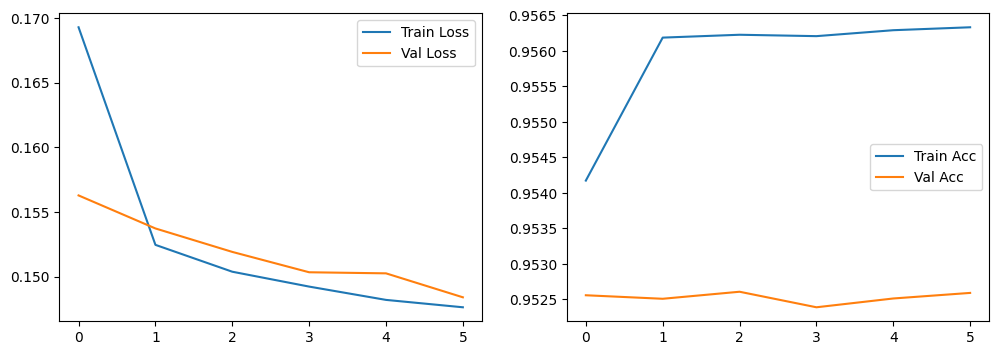

Generating Grad-CAM visualizations...
Ошибка при создании Grad-CAM: element 0 of tensors does not require grad and does not have a grad_fn
Ошибка при создании Grad-CAM: element 0 of tensors does not require grad and does not have a grad_fn
Ошибка при создании Grad-CAM: element 0 of tensors does not require grad and does not have a grad_fn
Ошибка при создании Grad-CAM: element 0 of tensors does not require grad and does not have a grad_fn
Ошибка при создании Grad-CAM: element 0 of tensors does not require grad and does not have a grad_fn
Ошибка при создании Grad-CAM: element 0 of tensors does not require grad and does not have a grad_fn
Ошибка при создании Grad-CAM: element 0 of tensors does not require grad and does not have a grad_fn
Ошибка при создании Grad-CAM: element 0 of tensors does not require grad and does not have a grad_fn
Ошибка при создании Grad-CAM: element 0 of tensors does not require grad and does not have a grad_fn
Ошибка при создании Grad-CAM: element 0 of tensors do

In [28]:
# Create model
model = create_model(device, num_classes=14)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

# Train
model, train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=6
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.show()

# Grad-CAM visualization
print("Generating Grad-CAM visualizations...")
plot_grad_cam_examples(model, val_loader, device, class_names)

# Save model
torch.save(model.state_dict(), 'chestxray_model.pth')
print("Model saved!")



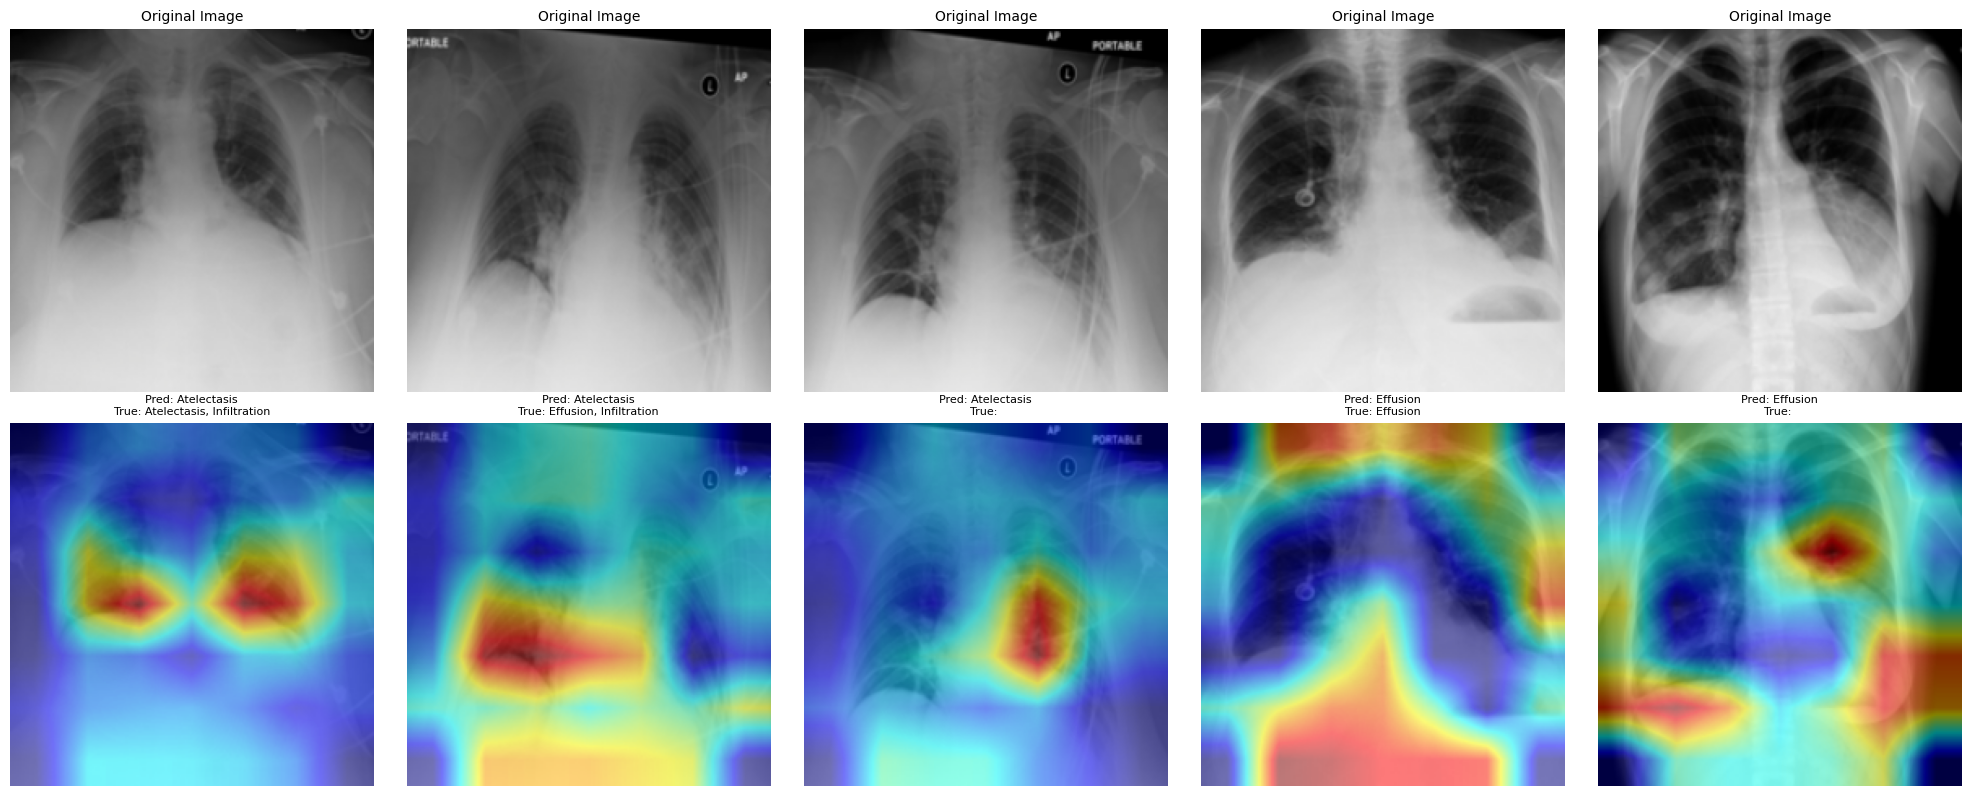

In [33]:
model1 = create_model(device, num_classes=14)
model1.load_state_dict(torch.load("/content/chestxray_model.pth"))
plot_grad_cam_examples(model1, val_loader, device, class_names)